In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 120

np.random.seed(0)

from PIL import Image, ImageDraw, ImageFont
from sklearn.neighbors import KDTree
import colour

import tqdm
from elman import ElmanNetwork, normalize

In [73]:
def drawText(msg, size=(200, 200)):
    # Making the grid
    # Big flex here

    # Note that I also uploaded the comic sans font file with my code:
    # this is why (comic sans is the best font)
    font = ImageFont.truetype("/home/jack/Documents/Crimson-Roman.ttf",30)

    # Create a blank image any draw our text on it
    image = Image.new("RGB", size)
    draw = ImageDraw.Draw(image)
    draw.text((size[0]//3, size[1]//3), msg, font=font)
    
    textImage = np.transpose(np.array(image)[::-1,:,0])
    xArr, yArr = np.where(textImage != 0)

    return xArr, yArr

def orderPoints(xArr, yArr):
# Order based on proximity

    remainingPoints = list(zip(xArr, yArr))

    orderedPoints = [(xArr[np.argmin(xArr)], yArr[np.argmin(xArr)])]
    del remainingPoints[np.argmin(xArr)]

    for i in range(len(xArr)-1):
        dist = np.sum((np.array(remainingPoints) - orderedPoints[-1])**2, axis=-1)
        ind = np.argmin(dist)
        orderedPoints.append(remainingPoints[ind])
        del remainingPoints[ind]

    orderedPoints = np.array(orderedPoints)
    
    return orderedPoints[:,0], orderedPoints[:,1]

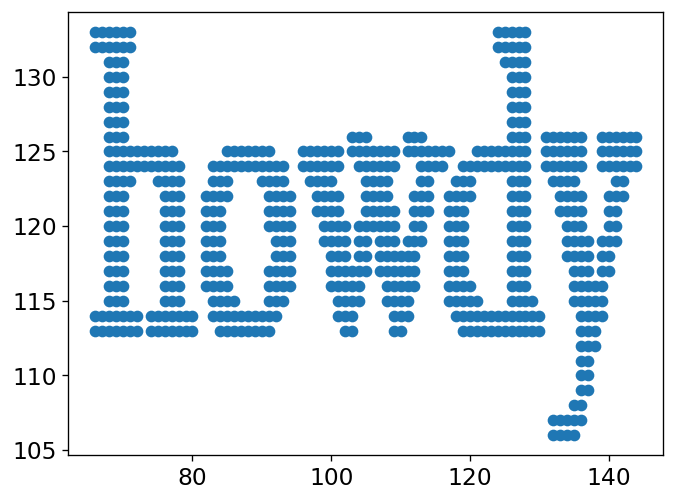

In [74]:
xArr, yArr = drawText('howdy')

plt.scatter(xArr, yArr)
plt.show()

In [75]:
msg = 'OIST'

xArr = [None]*len(msg)
yArr = [None]*len(msg)

for i in range(len(msg)):
    
    x, y = drawText(msg[i])
    x = normalize(x, normMin=.1+.8/len(msg)*i, normMax=.1+.8/len(msg)*(i+1))
    y = normalize(y, normMin=.40, normMax=.7)
    
    xArr[i], yArr[i] = orderPoints(x, y)

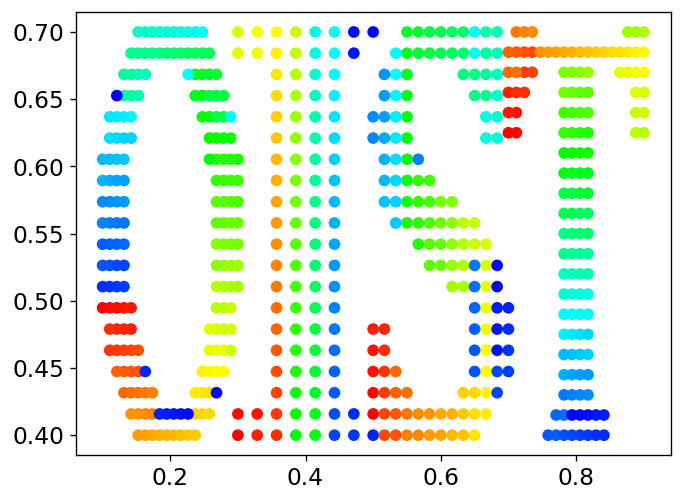

In [78]:
for i in range(len(xArr)):
    colourMap = colour.Color('Red').range_to(colour.Color('Blue'), len(xArr[i]))

    colourMap = [str(s) for s in colourMap]

    plt.scatter(xArr[i], yArr[i], c=colourMap)
plt.show()

In [ ]:
# Quite a few epochs
numEpochs = 100000
# How strong should the noise be that we add to the training data each epoch?
# This value is the width of the gaussian that the noise is sampled from
# (centered at 0).
noiseStrength = .001

# 30 hidden neurons seems fine for this
model = ElmanNetwork(inputDim=2,
                     contextDim=30,
                     outputDim=2,
                     learningRate=.1)

circleInputArr = np.array(list(zip(circleXArr, circleYArr)))[:-1]
circleTargetArr = np.array(list(zip(circleXArr, circleYArr)))[1:]

feInputArr = np.array(list(zip(feXArr, feYArr)))[:-1]
feTargetArr = np.array(list(zip(feXArr, feYArr)))[1:]

# So we can easily index both input and target arrays
inputArr = [circleInputArr, feInputArr]
targetArr = [circleTargetArr, feTargetArr]

errorArr = np.zeros(numEpochs) # list to store errors

# Mix up the order in which we train each shape
trainingOrder = [0]*int(np.floor(numEpochs*circleFigureEightTrainingSplit)) + [1]*int(np.floor(numEpochs*(1 - circleFigureEightTrainingSplit)))
np.random.shuffle(trainingOrder)

# In case rounding to integers has caused us to lose an element, we add it back
if len(trainingOrder) < numEpochs:
    trainingOrder += [0]* (numEpochs - len(trainingOrder))

for epoch in tqdm.tqdm(range(numEpochs)):
    # Context and output
    noiseArr = np.random.normal(0, noiseStrength, size=inputArr[trainingOrder[epoch]].shape)
    
    contextArr, outputArr = model.forwardSequence(inputArr[trainingOrder[epoch]] + noiseArr)
    errorArr[epoch]  = model.backwardSequence(inputArr[trainingOrder[epoch]] + noiseArr,
                                              contextArr, outputArr, targetArr[trainingOrder[epoch]])
    model.updateParameters()
    
model.save('models/text_renderer_oist.npz')